<a href="https://colab.research.google.com/github/krivi12/M2L_school/blob/main/%5BM2LS_2025%5D_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

---

Additional Notes and Setup (framework info, python imports etc)


In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn.functional as F

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib

In [4]:
from torchinfo import summary

### Dataset


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import matplotlib

# Parameters
n_samples = 50000
noise = 0.005
random_state = 42

# Generate data
X, y = make_moons(
    n_samples=n_samples,
    noise=noise,
    random_state=random_state
)

# Center and scale X
mu = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mu) / std


def plot_dataset():
    fig, ax = plt.subplots()

    # Pick two discrete colors from viridis
    cmap = matplotlib.colormaps["viridis"].resampled(2)  # 2 discrete colors
    colors = [cmap(0), cmap(1)]

    # Plot each class with its viridis color
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c=[colors[0]], s=12, label="0")
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c=[colors[1]], s=12, label="1")

    ax.set_title("Two Moons")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Set the plot limits
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

    # Add a simple legend
    ax.legend(title="Label")

In [6]:
import torch
import matplotlib.pyplot as plt


def plot_forward(X, y, alpha, sigma):
    """
    Visualize the VP-SDE forward process.

    Args:
        X (np.ndarray): Initial data of shape (N, 2)
        y (np.ndarray): Labels for coloring the scatter plot
        alpha (callable): Function alpha(t)
        sigma (callable): Function sigma(t)
    """
    # Convert numpy array to torch tensor
    X_tensor = torch.from_numpy(X).float()

    # Define the timesteps we want to visualize
    timesteps = torch.tensor(
        [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1.0])

    # Determine the number of rows and columns for the subplots
    num_timesteps = len(timesteps) + 1  # include final Normal(0,1)
    num_cols = 4
    num_rows = (num_timesteps + num_cols - 1) // num_cols

    # Set up the plot
    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    fig.suptitle("Forward Process", fontsize=16)
    axes = axes.flatten()

    # Forward process for each timestep
    for i, t in enumerate(timesteps):
        alpha_t = alpha(t)
        sigma_t = sigma(t)
        epsilon = torch.randn_like(X_tensor)
        X_t = alpha_t * X_tensor + sigma_t * epsilon

        ax = axes[i]
        ax.scatter(X_t[:, 0].numpy(), X_t[:, 1].numpy(),
                   s=10, c=y, cmap='viridis')
        ax.set_title(f"t = {t.item():.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.grid(True)

    # Final Normal(0,1) plot
    epsilon = torch.randn_like(X_tensor)
    final_ax = axes[num_timesteps - 1]
    final_ax.scatter(epsilon[:, 0].numpy(), epsilon[:, 1].numpy(), s=10)
    final_ax.set_title("Normal (0,1)")
    final_ax.set_xlabel("x")
    final_ax.set_ylabel("y")
    final_ax.set_xlim(-3, 3)
    final_ax.set_ylim(-3, 3)
    final_ax.grid(True)

    # Turn off any unused subplots
    for j in range(num_timesteps, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_schedule(alpha_fn, beta_fn, sigma_fn, t=None):
    """
    Plot beta(t), alpha(t), and sigma(t) side by side for t in [0,1].

    Args:
        alpha_fn: function t -> alpha(t)
        beta_fn: function t -> beta(t)
        sigma_fn: function t -> sigma(t)
        t: optional torch.Tensor of time values, default linspace(0,1,500)
    """
    if t is None:
        t = torch.linspace(0, 1, 500)

    b = beta_fn(t)
    a = alpha_fn(t)
    s = sigma_fn(t)

    cmap = plt.get_cmap("viridis")
    colors = [cmap(0.2), cmap(0.5), cmap(0.8)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].plot(t, b, color=colors[0])
    axs[0].set_title("beta(t)")
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("beta")

    axs[1].plot(t, a, color=colors[1])
    axs[1].set_title("alpha(t)")
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("alpha")

    axs[2].plot(t, s, color=colors[2])
    axs[2].set_title("sigma(t)")
    axs[2].set_xlabel("t")
    axs[2].set_ylabel("sigma")

    plt.tight_layout()
    plt.show()

In [7]:
def plot_denoising_trajectories(traj: np.ndarray, ground_truth_samples: np.ndarray, num_samples_to_plot: int = 4):
    """
    Plots the denoising trajectories from a standard Gaussian to a ground truth distribution.

    Args:
        traj (np.ndarray): A 3D numpy array of shape (num_trajectories, num_steps, 2)
                           representing the trajectories.
        ground_truth_samples (np.ndarray): A 2D numpy array of shape (num_samples, 2)
                                           representing the ground truth data points.
        num_samples_to_plot (int, optional): The number of trajectories to plot. Defaults to 4.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1. Ground truth (black background points, p0)
    ax.scatter(ground_truth_samples[:, 0], ground_truth_samples[:,
               1], c="black", s=3, label=r"$p_0$ (Ground truth)")

    # Pick colors from viridis
    cmap = matplotlib.colormaps["viridis"]
    colors = [cmap(i / max(1, num_samples_to_plot - 1))
              for i in range(num_samples_to_plot)]

    # 2. Plot trajectories, noises, and samples
    for i in range(num_samples_to_plot):
        color = colors[i]

        # Trajectory (light gray line)
        ax.plot(traj[i, :, 0], traj[i, :, 1],
                color="gray", alpha=0.2, linewidth=1)

        # Arrow (stronger gray)
        x0, y0 = traj[i, 0]
        x1, y1 = traj[i, -1]
        ax.annotate("",
                    xy=(x1, y1), xycoords='data',
                    xytext=(x0, y0), textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="gray", lw=1.2, alpha=0.6))

        # Initial noise (X marker)
        ax.scatter(x0, y0, c=[color], s=60, marker="x", linewidths=2,
                   label="Initial noise" if i == 0 else "")

        # Final sample (O marker)
        ax.scatter(x1, y1, c=[color], s=60, marker="o",  linewidths=1.2,
                   label="Final sample" if i == 0 else "")

    # 3. Gaussian contours (p1)
    xx, yy = np.meshgrid(
        np.linspace(-3, 3, 200),
        np.linspace(-3, 3, 200)
    )
    pos = np.dstack((xx, yy))
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    z = rv.pdf(pos)
    ax.contour(xx, yy, z, colors="gray", linestyles="dotted")

    # --- Legend entries for non-automatic elements ---
    # p1 (Gaussian)
    ax.plot([], [], color="gray", linestyle="dotted",
            label=r"$p_1$ (Standard Gaussian)")
    # Sampling trajectory
    ax.plot([], [], color="gray", alpha=0.2,
            linewidth=1, label="Sampling trajectory")

    ax.axis("equal")
    ax.set_title("Denoising using Reverse Process")
    ax.legend()
    plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
import matplotlib.cm as cm


def animate_trajectories(traj, downsample_points=2, downsample_frames=5, gif_path="denoising.gif"):
    """
    Animate a trajectory tensor and optionally save as GIF.

    Args:
        traj (np.ndarray): Trajectories of shape (num_points, num_timesteps, 2)
        downsample_points (int): Factor to downsample points for faster animation
        downsample_frames (int): Factor to downsample frames for faster animation
        gif_path (str): Path to save GIF
        show (bool): Whether to display GIF in notebook
    """
    # Downsample for speed
    traj_ds = traj[::downsample_points, ::downsample_frames, :]
    num_points, num_timesteps, _ = traj_ds.shape

    # Viridis colormap
    colors = cm.viridis(np.linspace(0, 1, num_points))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    scat = ax.scatter(traj_ds[:, 0, 0], traj_ds[:, 0, 1], s=5, c=colors)
    ax.set_xlim(np.min(traj_ds[:, :, 0]), np.max(traj_ds[:, :, 0]))
    ax.set_ylim(np.min(traj_ds[:, :, 1]), np.max(traj_ds[:, :, 1]))
    ax.set_title(f"Timestep: 0")

    # Animation update function
    def update(frame):
        scat.set_offsets(traj_ds[:, frame, :])
        ax.set_title(f"Timestep: {frame * downsample_frames}")
        return scat,

    # Create animation (does NOT repeat automatically)
    anim = FuncAnimation(
        fig,
        update,
        frames=num_timesteps,
        interval=20,
        blit=True,
        repeat=False
    )

    # Save as GIF
    anim.save(gif_path, writer=PillowWriter(fps=30))

In [9]:
batch_size = 2048
num_epochs = 1024
lr = 1e-3

In [10]:
device = torch.device(f"cuda:{0}")

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

dataset = TensorDataset(torch.from_numpy(X).float())
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
)

## Part I: Fundamentals of Continuous-Time Diffusion Models

---


### Dataset


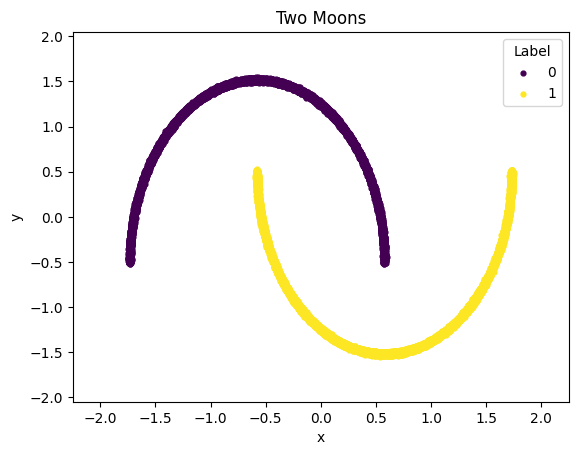

In [12]:
plot_dataset()

### Forward process

The forward process describes how clean data $\mathbf{x}_0$ is gradually perturbed with noise over (continous) time. It is formally specified as a stochastic differential equation.
There are many possible choices, but we focus on so called **variance-preserving SDE**,

$$
\mathrm{d}\mathbf{x} = -\tfrac{1}{2} \beta(t) \mathbf{x} \, \mathrm{d}t + \sqrt{\beta(t)} \, \mathrm{d}\mathbf{w},
$$

where $\beta(t)$ controls the noise rate and $\mathrm{d}\mathbf{w}$ is standard Brownian motion.

The forward process plays the role of **progressively destroying structure in the data** by injecting Gaussian noise in a controlled manner.

- At **early times** ($t \approx 0$), $\mathbf{x}_t$ is close to the original data.
- At **later times** ($t \to 1$), $\mathbf{x}_t$ becomes nearly pure Gaussian noise.

This gradual corruption provides an _interpolation_ between the complex data distribution and a simple Gaussian prior. The reverse process then learns to recover the clean part from the interpolation during generation.

We will use the following $\beta(t)$ schedule,

$$
\beta(t) = \beta_{\min} + t \, (\beta_{\max} - \beta_{\min}), \quad t \in [0, 1]
$$

Analytical solution to our (forward) SDE is $ X_t = \mathcal{N}(\mathbf{X}\_t; \, \alpha(t)\mathbf{x}\_0, \, \sigma^2(t)\mathbf{I}) $, where

1.  $
  \alpha(t) = \exp\!\Big(-\tfrac{1}{2} \int_0^t \beta(s) \, \mathrm{d}s\Big),
  $
2.  $
  \sigma^2(t) = 1 - \alpha(t)^2,
  $

and $\mathbf{I}$ is the identity matrix.


#### Task: Implement the forward process


In [13]:
def beta(t, beta_min=0.1, beta_max=20):
    """
    Linear beta schedule for VP-SDE.

    Args:
        t: torch.Tensor of shape (...), values in [0,1]
        beta_min: minimum beta
        beta_max: maximum beta

    Returns:
        beta(t): torch.Tensor of same shape as t
    """

    return beta_min + t * (beta_max - beta_min)


def alpha(t, beta_min=0.1, beta_max=20):
    """
    Compute alpha(t) for VP-SDE with linear beta schedule.

    Args:
        t: torch.Tensor of shape (...), values in [0,1]

    Returns:
        alpha: torch.Tensor same shape as t
    """
    first_integral = beta_min * t
    second_integral = 0.5 * (beta_max - beta_min) * t**2
    integral = first_integral + second_integral
    return torch.exp(-0.5 * integral)


def sigma(t, beta_min=0.1, beta_max=20):
    """
    Compute sigma(t) for VP-SDE with linear beta schedule.

    Args:
        t: torch.Tensor of shape (...), values in [0,1]

    Returns:
        sigma: torch.Tensor same shape as t
    """

    return (1 - alpha(t, beta_min, beta_max)**2) ** 0.5

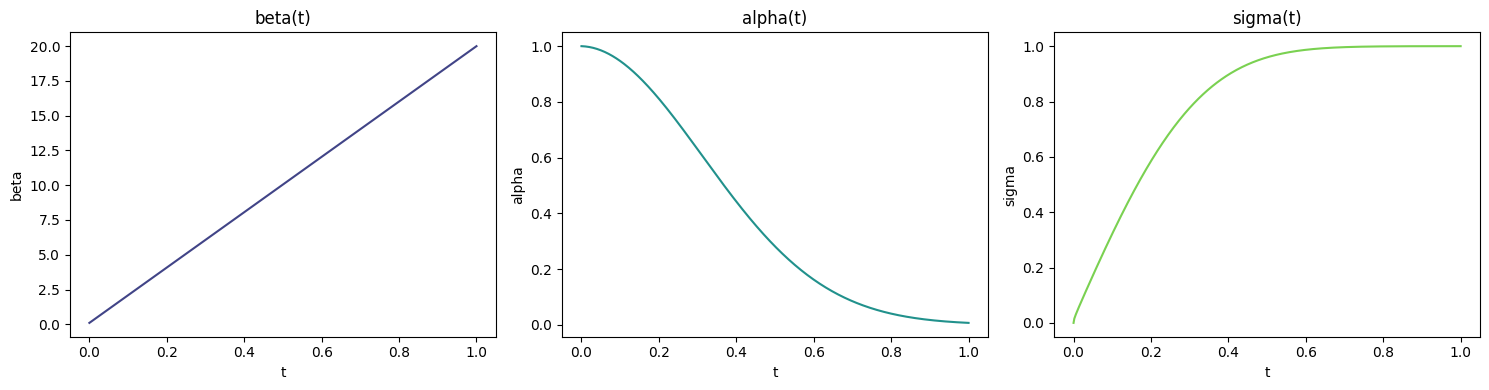

In [14]:
plot_schedule(alpha, beta, sigma)

Question: How do beta, alpha and sigma behave as time goes from 0 to 1. What do samples from p(x_t | x_0) look like?
Answers: Beta increases linearly, alpha gradually decreases -> less and less signal, while sigma gradually increases more and more noise.


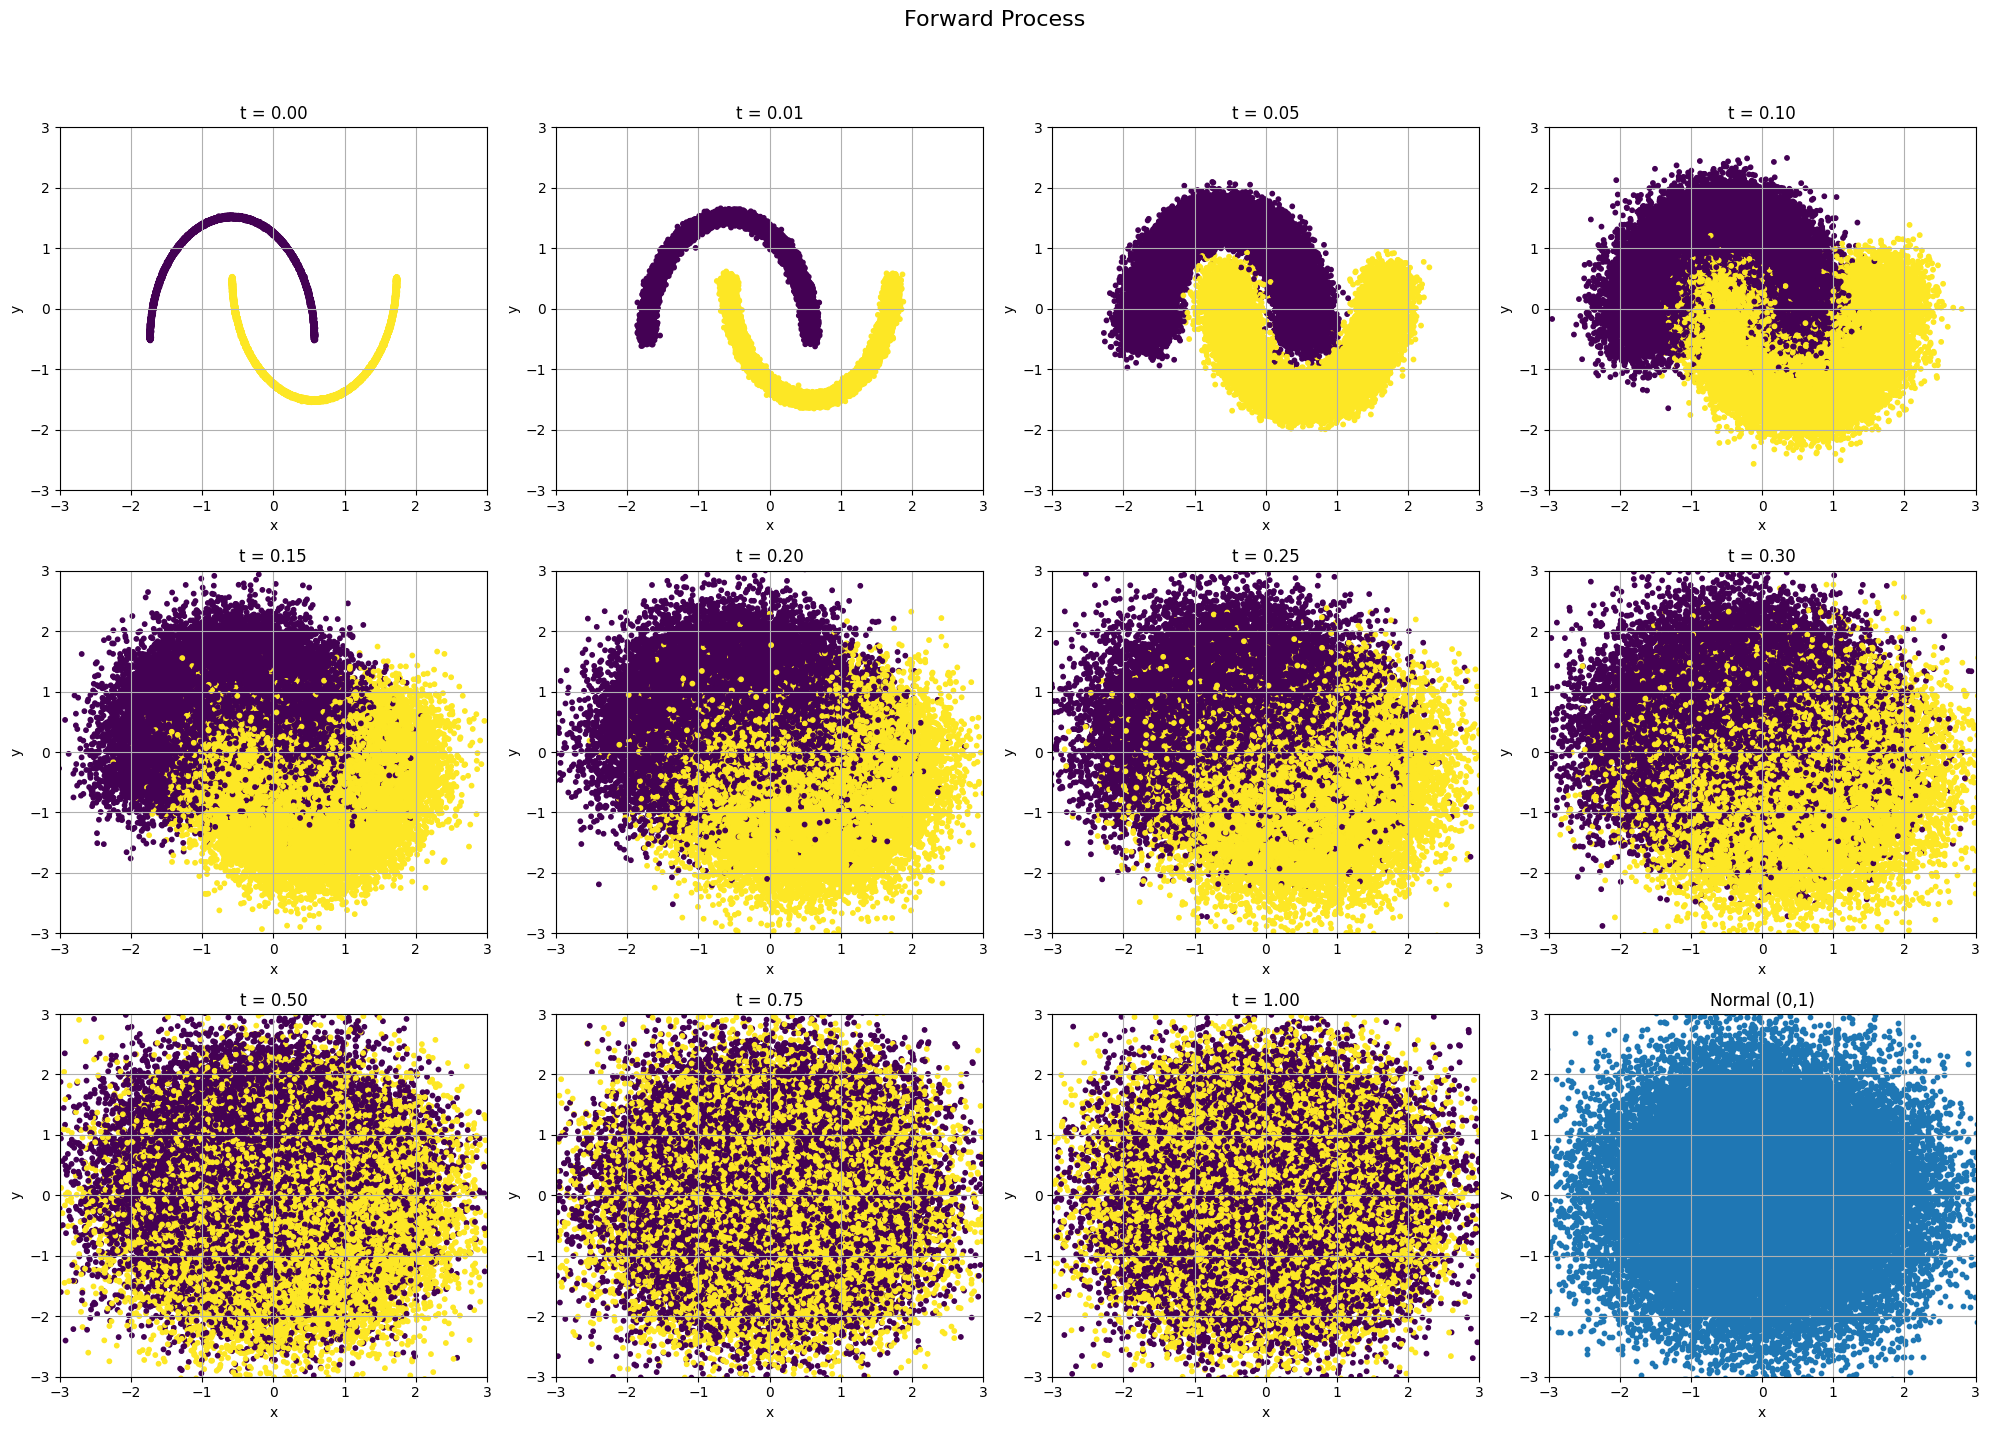

In [15]:
plot_forward(X, y, alpha, sigma)

### Score Model


#### Task: Implement a Time-Conditioned MLP (ScoreModel)

Implement a PyTorch model called `ScoreModel` that predicts a vector of the same dimension as its input, conditioned on both an input vector `x` and a scalar time `t`. The model should use a multi-layer perceptron (MLP) architecture with a configurable number of hidden layers and hidden units, using SiLU activation.

Specification:

1. **Inputs:**

   - `x`: Tensor of shape `(batch_size, dim)`.
   - `t`: Tensor of shape `(batch_size,)` representing a scalar time for each sample.

2. **Output:**

   - Tensor of shape `(batch_size, dim)`.

3. **Model Architecture:**

   - The model is an MLP that:

     1. Concatenates `x` and `t` along the last dimension to form a tensor of shape `(batch_size, dim + 1)`.
     2. Passes this through an **input linear layer** projecting `(dim + 1) → hidden_size`.
     3. Applies the **SiLU activation**.
     4. Passes through `num_blocks` **hidden layers**, each consisting of:
        - Linear layer: `hidden_size → hidden_size`
        - SiLU activation
     5. Passes through a **final linear layer** projecting `hidden_size → dim`.

**Example Usage:**

```python
dim = 2
model = ScoreModel(dim=dim, num_blocks=3, hidden_size=128)

x = torch.randn(16, dim)  # batch of 16 samples
t = torch.randn(16)       # corresponding times

output = model(x, t)      # shape: (16, 2)
```


In [16]:
import torch
import torch.nn as nn


class ScoreModel(nn.Sequential):
    def __init__(self, dim: int, num_blocks: int = 2, hidden_size: int = 64):
        super().__init__()
        self.dim = dim
        self.num_blocks = num_blocks
        self.hidden_size = hidden_size
        self.activation = torch.nn.SiLU()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.dim + 1, self.hidden_size))
        for _ in range(self.num_blocks):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))

        self.layers.append(nn.Linear(self.hidden_size, self.dim))



    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        for cnt, layer in enumerate(self.layers):
            if cnt == 0:
                x = torch.cat([x, t.unsqueeze(1)], dim=1)
                x = self.activation(layer(x))
            elif cnt == len(self.layers) - 1:
                x = layer(x)
            else:
                x = self.activation(layer(x))
        return x

In [17]:
model = ScoreModel(dim=2, hidden_size=256).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ScoreModel                               --
├─SiLU: 1-1                              --
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       1,024
│    └─Linear: 2-2                       65,792
│    └─Linear: 2-3                       65,792
│    └─Linear: 2-4                       514
Total params: 133,122
Trainable params: 133,122
Non-trainable params: 0

### Training with Denoising Score Matching


We will train our score model with Denoising Score Matching (DSM).

$$
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}_0, t, \mathbf{x}_t} \Big[ \lambda(t) \, \big\| s_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}_t} \log p_{t}(\mathbf{x}_t \mid \mathbf{x}_0) \big\|_2^2 \Big],
$$

where $\lambda(t)$ balances contributions across noise levels.

For numerical stability, we optimize
$$\mathcal{L}(\theta) = \mathbb{E}_{t \sim \mathcal{U}(0,1)} \left[ \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x}_0)}  \sigma(t)^2 \left[ \| \mathbf{s}_\theta(\mathbf{x}_t, t) + (\mathbf{x}_t - \alpha(t)\mathbf{x}_0)  \|_2^2 \right] \right]$$

We will estimate $\mathcal{L}(\theta)$ with a simple Monte-Carlo estimator

$$
\widehat{\mathcal{L}}(\theta) \;=\;
\frac{1}{B} \sum_{i=1}^{B}
 \sigma(t^{(i)})^2
\left\|\, s_\theta\!\big(\mathbf{x}_t^{(i)}, t^{(i)}\big)
\;+\;  (\mathbf{x}_t^{(i)} - \alpha(t^{(i)})\mathbf{x}_0^{(i)})  ,\right\|_2^{2},
$$

where each triplet $(\mathbf{x}_0^{(i)}, t^{(i)}, \mathbf{x}_t^{(i)})$ is drawn by:

- sampling a clean datapoint $\mathbf{x}_0^{(i)} \sim p_{\text{data}}$,
- sampling a time $t^{(i)} \sim \operatorname{Uniform}([0,1]) $,
- sampling $\mathbf{x}_t^{(i)} \sim p_t(\mathbf{x}_t \mid \mathbf{x}_0^{(i)})$, **using the closed-form solution** of our forward SDE.


#### Task: Implement the training step

Based on the provided Monte-Carlo estimator for the Denoising Score Matching loss, please complete the `training_step` function.

**Inputs:**

- `model`: An instance of `ScoreModel`, which is the neural network being trained.

- `x`: A `torch.Tensor` representing the batch of clean data points.

**Output:**

- A `torch.Tensor` representing the calculated loss value for the batch.

Your implementation should use previously implemented `alpha` and `sigma` functions to:

1. Sample a random time `t` and a random noise vector `z`.

2. Perturb the clean data `x` to create the noisy data `x_t`.

3. Compute the target score, which for this model is a scaled version of the actual score.

4. Return the Mean Squared Error (MSE) between the model's predicted score and the target score, averaged over both the input dimensions and the batch.


In [24]:
def training_step(model: ScoreModel, x: torch.Tensor) -> torch.Tensor:
    # x: (b, 2) [points]
    b, *_ = x.shape
    t = torch.rand(b, device=device) # Sample random time t
    # Perturb data with noise
    z = torch.randn_like(x)
    x_t = alpha(t).unsqueeze(1) * x + sigma(t).unsqueeze(1) * z

    # Compute the target score (scaled)
    target_score = -sigma(t).unsqueeze(1) * z

    # Get the model's predicted score
    predicted_score = model(x_t, t)

    # Compute the loss (MSE between predicted and target score)
    loss_fn = nn.MSELoss()
    loss = loss_fn(predicted_score, target_score)

    return loss

In [25]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=lr)

In [26]:
from tqdm import tqdm

log_every_steps = 128
total_epochs = 0

# Training loop with tqdm
for epoch in range(num_epochs):
    step = 0
    # Wrap the DataLoader with tqdm for a progress bar
    progress_loader = tqdm(
        loader,
        desc=f'epoch [{epoch+1}]',
        leave=False
    )
    for x, in progress_loader:
        # Move inputs to the device
        x = x.to(device)
        # Compute the loss
        loss = training_step(model, x)
        loss.backward()
        # Clip gradient norm
        torch.nn.utils.clip_grad_norm_(
            model.parameters(),
            max_norm=1.0
        )
        optimizer.step()
        # Backprop
        optimizer.zero_grad()
        if step % log_every_steps == 0:
            progress_loader.set_postfix(loss=loss.item())
        step += 1

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

### Sampling


#### Task: Sampling from a Variance-Preserving SDE using Euler-Maruyama

Recall that the reverse-time SDE is defined as:

$$
dx = \Big[-\frac{1}{2}\beta(t)x - \beta(t)s_\theta(x,t)\Big]\,dt + \sqrt{\beta(t)}\,d\bar{w}
$$

where:

- $x$ is the system state at time $t$, flowing **backwards from $T=1$ down to $\epsilon=1\text{e-5}$**. We **stop at $\epsilon$ instead of 0 for numerical stability**.
- $\beta(t)$ is the variance schedule function.
- $s_\theta(x,t)$ is the score function estimated by the model.
- $d\bar{w}$ is standard Brownian motion in reverse time.

  **Note:** the model is trained to regress $\sigma^2(t) s_\theta(x,t)$, so you need to **scale the model output by $1/\sigma^2(t)$** to get the actual score.

We discretize this SDE with **Euler-Maruyama** as:

$$
x_{t-\Delta t} = x_t - \Big[-\frac{1}{2}\beta(t)x_t - \beta(t)s_\theta(x_t,t)\Big]\Delta t + \sqrt{\beta(t)\Delta t}\,z
$$

where:

- $t$ is the current time step.
- $x_{t-\Delta t}$ is the state at the next (earlier) time step.
- $\Delta t = t_i - t_{i+1}$ is the positive step size.
- $s_\theta(x_t,t)$ is the estimated score function.
- $z$ is a standard Gaussian noise vector, corresponding to $d\bar{w}$.

**Your task:**

Implement a PyTorch function `sample_vp_sde_euler_maruyama` that:

1. **Inputs:**

   - `model: ScoreModel` – a PyTorch module that takes `(x, t)` and returns the **scaled score** $\sigma^2(t) s_\theta(x,t)$.
   - `num_samples: int` – number of samples to generate.
   - `sample_shape: List[int]` – shape of a single sample (default `[2]`).
   - `T: float` – starting time (default `1.0`).
   - `num_steps: int` – number of discrete steps for Euler-Maruyama (default `1000`).
   - `eps: float` – final time for numerical stability (default `1e-5`).
   - `device: str` – device for computation (CPU or GPU).

2. **Outputs:**

   - `x_T: torch.Tensor` – final state at $t \approx \epsilon$, shape `[num_samples] + sample_shape`.
   - `trajectory: torch.Tensor` – the full trajectory of all samples, shape `[num_samples, num_steps+1, *sample_shape]`.

**Hint:**

- Use `torch.full` to create a time tensor for the batch and `torch.randn_like` for the Brownian noise.
- Remember to **divide the model output by $\sigma^2(t)$** to obtain the true score.


In [ ]:
from typing import List, Tuple
import torch


@torch.inference_mode()
def sample_vp_sde_euler_maruyama(
    model: ScoreModel,
    num_samples: int,
    sample_shape: List[int] = [2],
    T=1.0,
    num_steps=1000,
    eps=1e-5,
    device='cpu',
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Create time steps from T down to eps, for numerical stability
    t_steps = torch.linspace(T, eps, num_steps + 1, device=device)
    # Start with a random noise vector for all samples
    x = torch.randn([num_samples]+sample_shape, device=device)
    # List to store the trajectory of each sample
    trajectory = [x.clone()]
    for i in range(num_steps):
        t = t_steps[i]
        "YOUR CODE GOES HERE"
        raise NotImplementedError()
    # Rearrange trajectory
    trajectory = (
        torch
        .stack(trajectory, dim=0)
        .permute(1, 0, 2)
    )
    return (
        trajectory[:, -1, :],
        trajectory
    )

In [ ]:
x, traj = sample_vp_sde_euler_maruyama(
    model,
    num_samples=1000,
    num_steps=1000,
    device=device
)
x = x.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

x.shape, traj.shape

**Denoising animation**


In [ ]:
animate_trajectories(traj)

In [ ]:
display(Image(filename="denoising.gif"))

**Denoising summary**


In [ ]:
plot_denoising_trajectories(traj, X)